# COVID-19 Lung Leision Segmentation

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score

# append project directory to path
import sys
project_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(project_dir, "data")
model_dir = os.path.join(project_dir, "model")
sys.path.append(project_dir)
print(f"project directory: {project_dir}")
print(f"data directory: {data_dir}")
print(f"model directory: {model_dir}")

project directory: /home/jinyijia/bme4460/Covid19_Leision_Segmentation
data directory: /home/jinyijia/bme4460/Covid19_Leision_Segmentation/data
model directory: /home/jinyijia/bme4460/Covid19_Leision_Segmentation/model


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# check gpu
cuda = torch.cuda.is_available()
print("GPU available:", cuda)

# seeding
torch.manual_seed(4460)
np.random.seed(4460)

GPU available: True


In [4]:
from basic_dataset import BasicDataset

<b> Load Full Datasets </b>

In [5]:
train_dataset = BasicDataset(os.path.join(data_dir, 'PairedTrainData'))
valid_dataset = BasicDataset(os.path.join(data_dir, 'PairedValidData'))
test_dataset = BasicDataset(os.path.join(data_dir, 'PairedTestData'))
len(train_dataset), len(valid_dataset), len(test_dataset)

(1202, 341, 275)

<b> Check Data Shape </b>

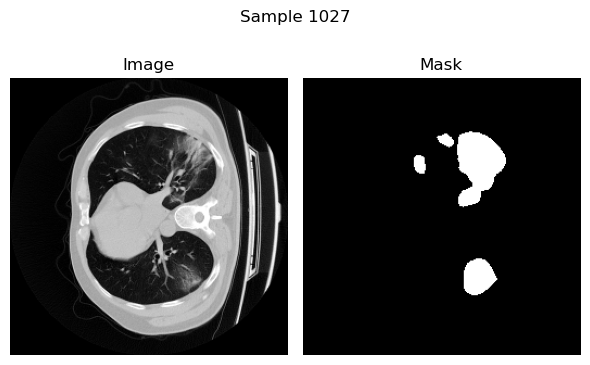

x shape: torch.Size([1, 256, 256])
y shape: torch.Size([256, 256])


In [6]:
from utils import show_pair

# show a random pair (CT image, infection mask)
sample_data = train_dataset[np.random.randint(0, len(train_dataset))]
x, y, idx = sample_data['image'], sample_data['mask'], sample_data['img_id']
show_pair(x[0], y, idx)
print(f'x shape: {x.shape}')
print(f'y shape: {y.shape}')


In [12]:
# describe image 
pd.DataFrame(x.flatten()).describe() # describe image 

,0
count,65536.000000
mean,0.254639
std,0.317767
min,0.000000
25%,0.011765
50%,0.066667
75%,0.650980
max,1.000000


In [13]:
# describe mask
pd.DataFrame(y.flatten()).describe() # describe image 

,0
count,65536.000000
mean,0.046844
std,0.211307
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<b> Show Data Split </b>

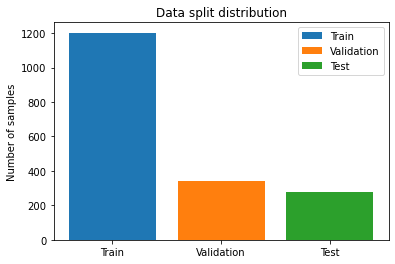

In [14]:
from utils import show_datasets

show_datasets(train_dataset, valid_dataset, test_dataset)

### Train

<b>Basic UNet-1024</b>

In [ ]:
from networks import UNet, UNet_Reduced
from run_network import get_total_params

# define model
my_UNet = UNet('MyUNet_256', 1, 2) # output classes = 2
my_UNet.cuda()
print(f"{my_UNet.name} total model parameters:", get_total_params(my_UNet))

<b>Reduced UNet-256</b>

In [7]:
from networks import UNet, UNet_Reduced
from run_network import get_total_params

my_UNet = UNet_Reduced('MyUNet_red_256', 1, 2) # output classes = 2
my_UNet.cuda()

print(f"{my_UNet.name} total model parameters:", get_total_params(my_UNet))

MyUNet_red_256 total model parameters: 1846370


<b>Attention U-Net</b>

In [1]:
from networks import AttU_Net
from run_network import get_total_params

my_UNet = AttU_Net('AttU_Net_256', 1, 2) # output classes = 2
my_UNet.cuda()

print(f"{my_UNet.name} total model parameters:", get_total_params(my_UNet))

AttU_Net_256 total model parameters: 34877486


<b>ResU-Net++</b>

In [6]:
from networks import ResUnetPlusPlus
from run_network import get_total_params

my_UNet = ResUnetPlusPlus('ResUnetPlusPlus_256', 1, 2) # output classes = 2
my_UNet.cuda()

print(f"{my_UNet.name} total model parameters:", get_total_params(my_UNet))

ResUnetPlusPlus total model parameters: 14481445


<b>R2AttU-Net</b>

In [1]:
from networks import R2AttU_Net
from run_network import get_total_params

my_UNet = R2AttU_Net('R2AttU_Net_256', 1, 2) # output classes = 2
my_UNet.cuda()

print(f"{my_UNet.name} total model parameters:", get_total_params(my_UNet))

R2AttU_Net_256 total model parameters: 9867486


<b>CAResU-Net</b>

In [1]:
from networks import CARes_Unet
from run_network import get_total_params

my_UNet = CARes_Unet('CARes_Unet_256', 1, 2) # output classes = 2
my_UNet.cuda()

print(f"{my_UNet.name} total model parameters:", get_total_params(my_UNet))

CARes_Unet_256 total model parameters: 56518418


In [5]:
from basic_dataset import BasicDataset

# Re-create train, validation, and test dataset instances to reduce the number of samples and expedite the training process.
train_dataset = BasicDataset(os.path.join(data_dir, 'PairedTrainData'), n_sample=1200)
valid_dataset = BasicDataset(os.path.join(data_dir, 'PairedValidData'), n_sample=240)
test_dataset = BasicDataset(os.path.join(data_dir, 'PairedTestData'), n_sample=240)

train_dataloader = DataLoader(train_dataset, batch_size=8, num_workers=2, pin_memory=True, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=8, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, num_workers=2, pin_memory=True)

<b>Initial Weights </b>

Although we have not trained our model, we may see the output with random weights. Thus, we will pull a batch of test data loader, get the network's output, and plot it.

Sample batch 'image 'shape is: torch.Size([16, 1, 256, 256])
Sample batch 'mask' shape is: torch.Size([16, 256, 256])
Predicted mask shape is: torch.Size([16, 2, 256, 256])


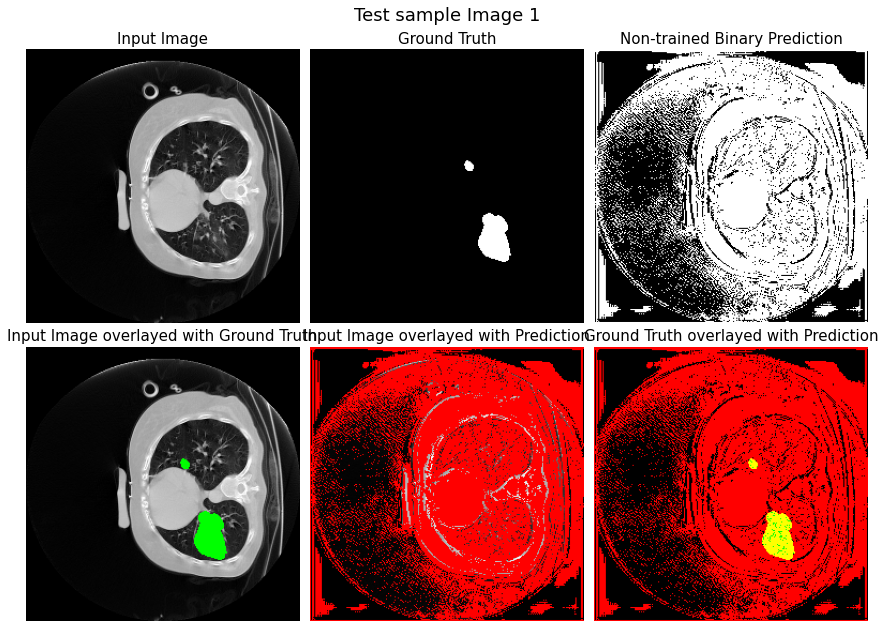

In [6]:
from utils import show_mask

show_mask(my_UNet, test_dataloader)

### 3. Train the model

In [8]:
from run_network import get_class_weight
# lr decay 
optimizer = torch.optim.Adam(my_UNet.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.5)

# use class weight for imbalanced data
class_weights = get_class_weight(train_dataset)
class_weights = torch.tensor([0.1, 1.], dtype=torch.float).cuda()
criteria = nn.CrossEntropyLoss(weight=class_weights)


In [9]:
from run_network import train_net

# train 
EPOCHS = 50
train_loss, train_dice, train_jaccard, valid_loss, valid_dice, valid_jaccard = train_net(my_UNet, EPOCHS, train_dataloader, valid_dataloader, optimizer, criteria, scheduler= lr_scheduler, save_dir = model_dir)

RuntimeError: CUDA out of memory. Tried to allocate 3.12 GiB (GPU 0; 14.76 GiB total capacity; 9.36 GiB already allocated; 2.63 GiB free; 9.97 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

```
AttU-net:
Test Loss: 0.35525790924827255, Test DICE score: 0.6670826077461243, Test Jaccard score: 0.5097016096115112, Test overall accuracy: 0.9784472147623698
Test Loss: 0.3813398579756419, Test DICE score: 0.6908388137817383, Test Jaccard score: 0.5335437655448914, Test overall accuracy: 0.9786556243896485

```

### Display results

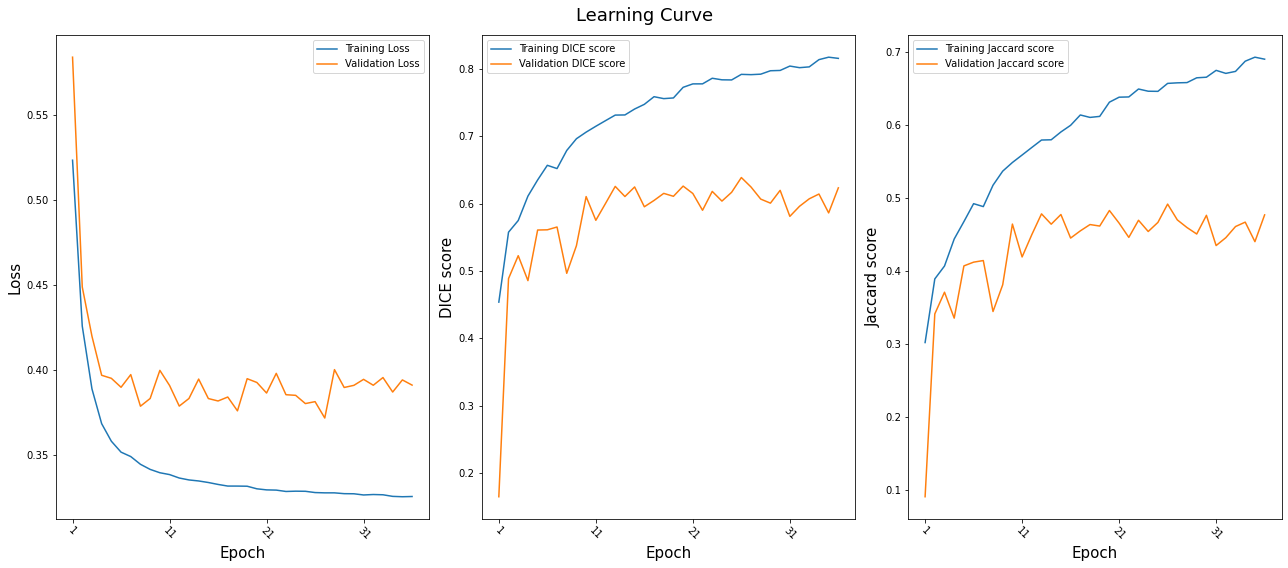

In [13]:
from run_network import show_training

show_training(EPOCHS, train_loss, valid_loss, train_dice, valid_dice, train_jaccard, valid_jaccard)

<b> Load Best Model </b>

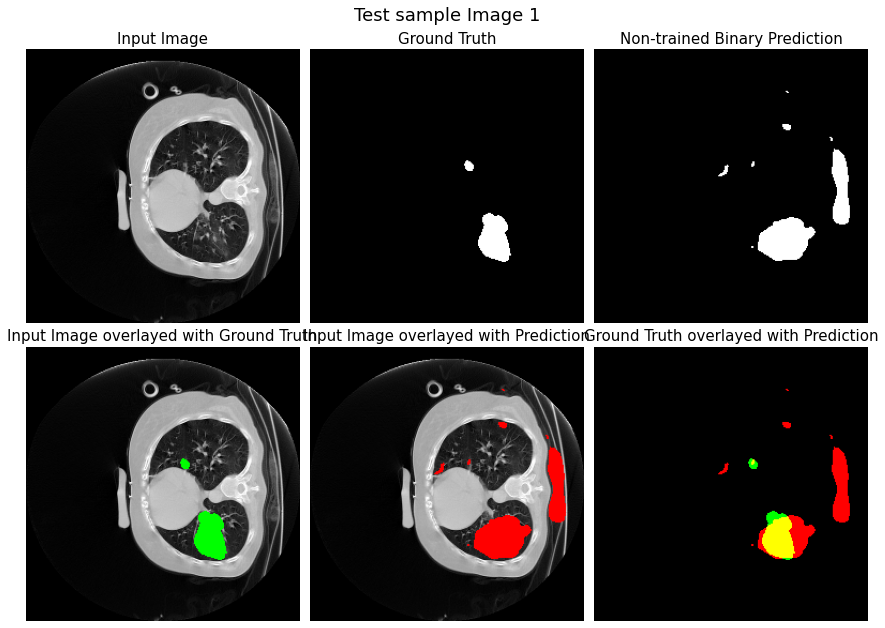

In [6]:
from utils import show_mask

# load best model
best_epoch = np.argmax(valid_dice) + 1 # epochs starts at 1
print(f'Best epoch is epoch {best_epoch}')
state_dict = torch.load(os.path.join(model_dir, my_UNet.name, f'epoch_{best_epoch:03}.pth'))

# save best model as best.pth
torch.save(state_dict, os.path.join(model_dir, my_UNet.name, f'best.pth'))
state_dict = torch.load(os.path.join(model_dir, my_UNet.name, f'best.pth'))



my_UNet.load_state_dict(state_dict)
my_UNet.cuda()

# check the performance of the best model on our previously pulled example
show_mask(my_UNet, test_dataloader, verbose=False)

<b>Test Data </b>

In [15]:
from run_network import test_net
# best_epoch = 80
# state_dict = torch.load(os.path.join(model_dir, my_UNet.name, f'epoch_{best_epoch:03}.pth'))

# my_UNet.load_state_dict(state_dict)
# my_UNet.cuda()

# run best model on testdata
test_loss, test_dice, test_jaccard, test_accuracy, test_CM = test_net(my_UNet, test_dataloader, criteria, save_dir=model_dir)

print(f'Test Loss: {test_loss}, Test DICE score: {test_dice}, Test Jaccard score: {test_jaccard}, Test overall accuracy: {test_accuracy}')

Test Loss: 0.3813398579756419, Test DICE score: 0.6908388137817383, Test Jaccard score: 0.5335437655448914, Test overall accuracy: 0.9786556243896485


Text(0.5, 69.0, 'predicted labels')

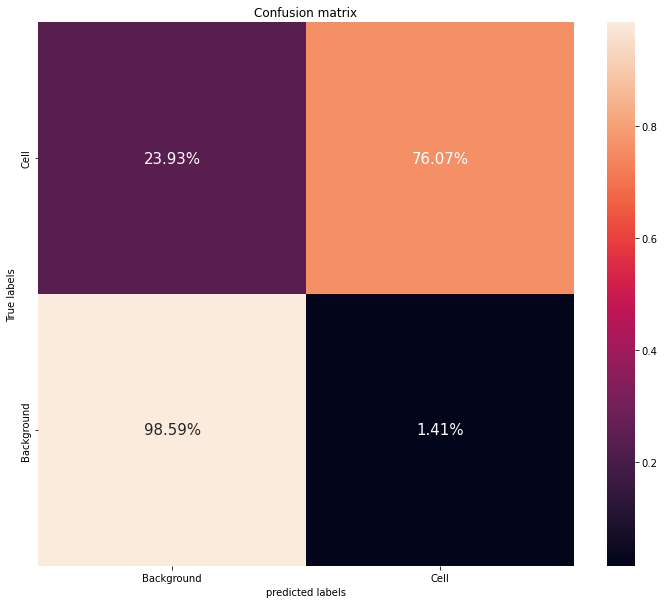

In [16]:
# confusion matrix
df_cm = pd.DataFrame(test_CM, index = ['Background', 'Cell'],
                     columns = ['Background', 'Cell'])
plt.figure(figsize = (12,10))
plt.title('Confusion matrix')
sns.heatmap(df_cm, annot = True, fmt='.2%', annot_kws = {"size": 15})
plt.ylim([0, 2])
plt.ylabel('True labels')
plt.xlabel('predicted labels')